מחברת מסכמת של הפרויקט שלי
השלבים עד כה:
ייבוא ספריית צילומי רנטגן של חזה והרצת3 מורים אופציונלים
resnet50, afficient netB0, afficient netB3
דיסטילציה של שלושתם על תלמיד resnet18
בדיקה מי המורה עם התוצאות דיסטילציה הכי טובות

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
!mkdir Git

mkdir: cannot create directory ‘Git’: File exists


In [5]:
%cd Git/

/content/drive/MyDrive/Git


In [6]:
!git  clone https://github.com/Shani-rb/Distillation_project.git


Cloning into 'Distillation_project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [7]:
%cd Distillation_project/

/content/drive/MyDrive/Git/Distillation_project


In [8]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [13]:
!pip uninstall -y sympy
!pip install sympy==1.12


Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 60.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.12 which is incompatible.


In [1]:
pip install torch torchvision timm numpy matplotlib medmnist

In [2]:
from google.colab import drive

# חיבור ל-Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import timm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# פריקת ה-ZIP (אם לא פרקת ב-Drive)
zip_path = "/content/drive/My Drive/chest-xray-pneumonia.zip"
!unzip -q "$zip_path" -d "/content"  # פורק לתיקייה זמנית ב-Colab

# הגדרת מכשיר
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# טרנספורמציה עם אוגמנטציה
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# טעינת הדאטהסט
data_dir = "/content/chest_xray"
train_dataset = ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = ImageFolder(root=f"{data_dir}/test", transform=transform)

# פיצול train ל-train ו-val
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_size))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)  # Batch Size קטן יותר
val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# אימון המורה - EfficientNet-B0
teacher_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)
teacher_model = teacher_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# מילון לשמירת היסטוריית Loss עבור הגרפים
teacher_history = {'train_loss': [], 'val_loss': []}

teacher_model.train()
for epoch in range(15):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    teacher_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = teacher_model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss = val_loss / len(val_loader)

    # שמירת ה-Loss להיסטוריה
    teacher_history['train_loss'].append(train_loss)
    teacher_history['val_loss'].append(val_loss)

    print(f"Teacher (EfficientNet-B0) - Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(teacher_model.state_dict(), '/content/drive/My Drive/b0.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    teacher_model.train()

teacher_model.load_state_dict(torch.load('/content/drive/My Drive/b0.pth'))



Teacher (EfficientNet-B0) - Epoch 1, Train Loss: 0.4347, Val Loss: 0.0498
Teacher (EfficientNet-B0) - Epoch 2, Train Loss: 0.0805, Val Loss: 0.0788
Teacher (EfficientNet-B0) - Epoch 3, Train Loss: 0.0497, Val Loss: 0.0407
Teacher (EfficientNet-B0) - Epoch 4, Train Loss: 0.0497, Val Loss: 0.0420
Teacher (EfficientNet-B0) - Epoch 5, Train Loss: 0.0468, Val Loss: 0.0837
Teacher (EfficientNet-B0) - Epoch 6, Train Loss: 0.0438, Val Loss: 0.0232
Teacher (EfficientNet-B0) - Epoch 7, Train Loss: 0.0396, Val Loss: 0.0739
Teacher (EfficientNet-B0) - Epoch 8, Train Loss: 0.0514, Val Loss: 0.0302
Teacher (EfficientNet-B0) - Epoch 9, Train Loss: 0.0249, Val Loss: 0.0301
Early stopping triggered!


<All keys matched successfully>

In [1]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return accuracy, avg_loss


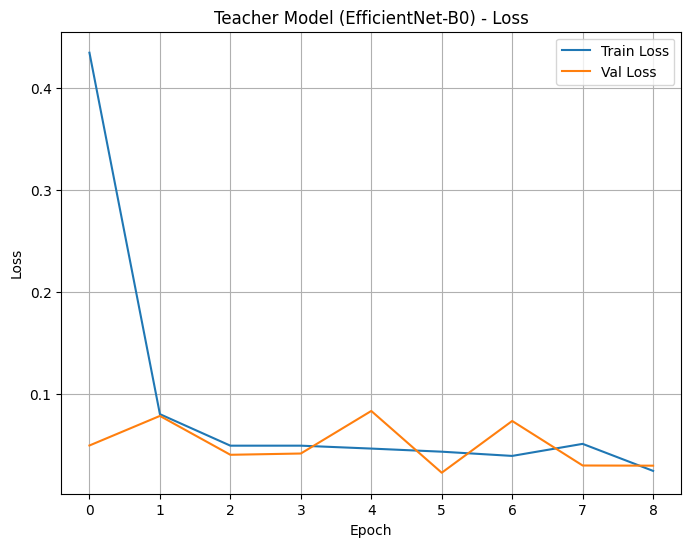


Summary Table for EfficientNet-B0:
------------------------------------------------------------
| Model            | Test Loss | Test Accuracy |
------------------------------------------------------------
| EfficientNet-B0  | 1.3413    | 79.97%       |
------------------------------------------------------------


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# יצירת גרף Loss
plt.figure(figsize=(8, 6))
plt.plot(teacher_history['train_loss'], label='Train Loss')
plt.plot(teacher_history['val_loss'], label='Val Loss')
plt.title('Teacher Model (EfficientNet-B0) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# חישוב Test Loss ו-Accuracy
final_test_acc, final_test_loss = evaluate(teacher_model, test_loader)

# טבלה מסכמת
print("\nSummary Table for EfficientNet-B0:")
print("-" * 60)
print("| Model            | Test Loss | Test Accuracy |")
print("-" * 60)
print(f"| EfficientNet-B0  | {final_test_loss:.4f}    | {final_test_acc:.2f}%       |")
print("-" * 60)

In [ ]:
# אימון המורה - EfficientNet-B3
teacher_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=2)
teacher_model = teacher_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# מילון לשמירת היסטוריית Loss עבור הגרפים
teacher_history = {'train_loss': [], 'val_loss': []}

teacher_model.train()
for epoch in range(15):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    teacher_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = teacher_model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss = val_loss / len(val_loader)

    # שמירת ה-Loss להיסטוריה
    teacher_history['train_loss'].append(train_loss)
    teacher_history['val_loss'].append(val_loss)

    print(f"Teacher (EfficientNet-B3) - Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(teacher_model.state_dict(), '/content/drive/My Drive/b3.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    teacher_model.train()

teacher_model.load_state_dict(torch.load('/content/drive/My Drive/b3.pth'))



model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Teacher (EfficientNet-B3) - Epoch 1, Train Loss: 0.3568, Val Loss: 0.0869
Teacher (EfficientNet-B3) - Epoch 2, Train Loss: 0.0678, Val Loss: 0.0604
Teacher (EfficientNet-B3) - Epoch 3, Train Loss: 0.0626, Val Loss: 0.0395
Teacher (EfficientNet-B3) - Epoch 4, Train Loss: 0.0416, Val Loss: 0.0630
Teacher (EfficientNet-B3) - Epoch 5, Train Loss: 0.0360, Val Loss: 0.0468
Teacher (EfficientNet-B3) - Epoch 6, Train Loss: 0.0408, Val Loss: 0.1026
Early stopping triggered!


<All keys matched successfully>

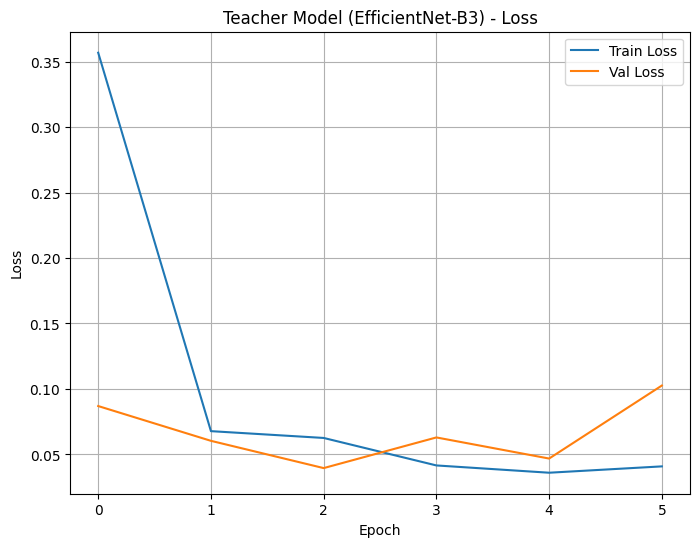


Summary Table for EfficientNet-B3:
------------------------------------------------------------
| Model            | Test Loss | Test Accuracy |
------------------------------------------------------------
| EfficientNet-B3  | 1.0427    | 80.61%       |
------------------------------------------------------------


In [ ]:
# יצירת גרף Loss
plt.figure(figsize=(8, 6))
plt.plot(teacher_history['train_loss'], label='Train Loss')
plt.plot(teacher_history['val_loss'], label='Val Loss')
plt.title('Teacher Model (EfficientNet-B3) - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# חישוב Test Loss ו-Accuracy
final_test_acc, final_test_loss = evaluate(teacher_model, test_loader)

# טבלה מסכמת
print("\nSummary Table for EfficientNet-B3:")
print("-" * 60)
print("| Model            | Test Loss | Test Accuracy |")
print("-" * 60)
print(f"| EfficientNet-B3  | {final_test_loss:.4f}    | {final_test_acc:.2f}%       |")
print("-" * 60)

In [ ]:
# אימון המורה - ResNet-50
teacher_model = models.resnet50(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 2)
teacher_model = teacher_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# מילון לשמירת היסטוריית Loss עבור הגרפים
teacher_history= {'train_loss': [], 'val_loss': []}

teacher_model.train()
for epoch in range(15):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    teacher_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = teacher_model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss = val_loss / len(val_loader)

    # שמירת ה-Loss להיסטוריה
    teacher_history['train_loss'].append(train_loss)
    teacher_history['val_loss'].append(val_loss)

    print(f"Teacher (ResNet-50) - Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(teacher_model.state_dict(), '/content/drive/My Drive/resnet50.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    teacher_model.train()

teacher_model.load_state_dict(torch.load('/content/drive/My Drive/resnet50.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


Teacher (ResNet-50) - Epoch 1, Train Loss: 0.1836, Val Loss: 0.3164
Teacher (ResNet-50) - Epoch 2, Train Loss: 0.1250, Val Loss: 0.0619
Teacher (ResNet-50) - Epoch 3, Train Loss: 0.1070, Val Loss: 0.2235
Teacher (ResNet-50) - Epoch 4, Train Loss: 0.1010, Val Loss: 0.1167
Teacher (ResNet-50) - Epoch 5, Train Loss: 0.1053, Val Loss: 0.2314
Early stopping triggered!


<All keys matched successfully>

In [ ]:
# הערכה על סט הבדיקה
test_acc, test_loss = evaluate(teacher_resnet50, test_loader)

# הדפסת הטבלה
print("\nSummary Table for ResNet-50:")
print("-" * 60)
print("| Model            | Test Loss | Test Accuracy |")
print("-" * 60)
print(f"| ResNet-50        | {test_loss:.4f}    | {test_acc:.2f}%       |")
print("-" * 60)



Summary Table for ResNet-50:
------------------------------------------------------------
| Model            | Test Loss | Test Accuracy |
------------------------------------------------------------
| ResNet-50        | 0.7509    | 80.13%       |
------------------------------------------------------------


ה־Teacher הכי טוב לדיסטילציה הוא זה שמבצע הכי טוב על סט הבדיקה – כלומר:

יש לו דיוק (accuracy) הכי גבוה
ורצוי גם loss נמוך


In [ ]:
# טעינת EfficientNet-B0
teacher_b0 = timm.create_model('efficientnet_b0', pretrained=False, num_classes=2)
teacher_b0 = teacher_b0.to(device)
teacher_b0.load_state_dict(torch.load('/content/drive/My Drive/b0.pth'))
b0_test_acc, b0_test_loss = evaluate(teacher_b0, test_loader)

# טעינת EfficientNet-B3
teacher_b3 = timm.create_model('efficientnet_b3', pretrained=False, num_classes=2)
teacher_b3 = teacher_b3.to(device)
teacher_b3.load_state_dict(torch.load('/content/drive/My Drive/b3.pth'))
b3_test_acc, b3_test_loss = evaluate(teacher_b3, test_loader)

# טעינת ResNet-50
teacher_resnet50 = models.resnet50(pretrained=False)
teacher_resnet50.fc = nn.Linear(teacher_resnet50.fc.in_features, 2)
teacher_resnet50 = teacher_resnet50.to(device)
teacher_resnet50.load_state_dict(torch.load('/content/drive/My Drive/resnet50.pth'))
resnet50_test_acc, resnet50_test_loss = evaluate(teacher_resnet50, test_loader)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# טבלה משווה
print("\nSummary Table for All Teachers:")
print("-" * 60)
print("| Model            | Test Loss | Test Accuracy |")
print("-" * 60)
print(f"| EfficientNet-B0  | {b0_test_loss:.4f}    | {b0_test_acc:.2f}%       |")
print(f"| EfficientNet-B3  | {b3_test_loss:.4f}    | {b3_test_acc:.2f}%       |")
print(f"| ResNet-50        | {resnet50_test_loss:.4f}    | {resnet50_test_acc:.2f}%       |")
print("-" * 60)

# זיהוי המודל הטוב ביותר
best_model = max([
    ('EfficientNet-B0', b0_test_acc),
    ('EfficientNet-B3', b3_test_acc),
    ('ResNet-50', resnet50_test_acc)
], key=lambda x: x[1])
print(f"\nBest performing teacher: {best_model[0]} with Test Accuracy: {best_model[1]:.2f}%")



Summary Table for All Teachers:
------------------------------------------------------------
| Model            | Test Loss | Test Accuracy |
------------------------------------------------------------
| EfficientNet-B0  | 1.3310    | 81.25%       |
| EfficientNet-B3  | 1.0275    | 81.41%       |
| ResNet-50        | 0.7659    | 78.69%       |
------------------------------------------------------------

Best performing teacher: EfficientNet-B3 with Test Accuracy: 81.41%


המודל עם הביצועים הטובים ביותר הוא

efficient b3

נבדוק איזה שילוב של טמפרטורה ואלפא נותן את התוצאות הטובות ביותר

In [ ]:
from torchvision import models

def create_student_model():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model


In [ ]:
# יצירת מודל מורה (מבנה תואם למה שאימנת)
teacher_model = timm.create_model('efficientnet_b3', pretrained=False, num_classes=2)
teacher_model = teacher_model.to(device)

# טעינת המשקלים
teacher_model.load_state_dict(torch.load('/content/drive/My Drive/b3.pth', map_location=device))

# הגדרת מצב הערכה (חשוב)
teacher_model.eval()
teacher_model = teacher_model.to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

temperatures = [1, 2, 5, 10]
alphas = [0.1, 0.5, 0.9]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = []

patience = 3  # כמה אפוקים מחכה לפני עצירה מוקדמת

for T in temperatures:
    for alpha in alphas:
        print(f"Training Student: Temperature={T}, Alpha={alpha}")

        student = create_student_model().to(device)  # ResNet18
        teacher = teacher_model.to(device)
        teacher.eval()

        optimizer = optim.Adam(student.parameters(), lr=1e-3)
        criterion_ce = nn.CrossEntropyLoss()

        best_val_loss = float('inf')
        patience_counter = 0

        epochs = 10

        for epoch in range(epochs):
            student.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.no_grad():
                    teacher_outputs = teacher(images)

                student_outputs = student(images)

                loss_ce = criterion_ce(student_outputs, labels)
                loss_kd = F.kl_div(
                    F.log_softmax(student_outputs / T, dim=1),
                    F.softmax(teacher_outputs / T, dim=1),
                    reduction='batchmean'
                ) * (T * T)

                loss = alpha * loss_kd + (1 - alpha) * loss_ce
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)

            # חישוב loss ולידציה
            student.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:  # צריך שיהיה val_loader מוכן מראש
                    images, labels = images.to(device), labels.to(device)
                    outputs = student(images)
                    val_loss += criterion_ce(outputs, labels).item()
            val_loss /= len(val_loader)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # בדיקת Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # שמירת המודל הטוב ביותר
                torch.save(student.state_dict(), 'best_student.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered!")
                    break

        # טעינת המודל הטוב ביותר
        student.load_state_dict(torch.load('best_student.pth'))

        # הערכה על סט הבדיקה
        student.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        results.append({
            "Temperature": T,
            "Alpha": alpha,
            "Test Accuracy": test_accuracy
        })

for r in results:
    print(r)


Training Student: Temperature=1, Alpha=0.1
Epoch 1/10, Train Loss: 0.2805, Val Loss: 0.1673
Epoch 2/10, Train Loss: 0.1875, Val Loss: 0.3447
Epoch 3/10, Train Loss: 0.1386, Val Loss: 0.1677
Epoch 4/10, Train Loss: 0.1325, Val Loss: 0.1449
Epoch 5/10, Train Loss: 0.1212, Val Loss: 0.2884
Epoch 6/10, Train Loss: 0.0992, Val Loss: 0.1905
Epoch 7/10, Train Loss: 0.0973, Val Loss: 0.0951
Epoch 8/10, Train Loss: 0.0921, Val Loss: 0.1782
Epoch 9/10, Train Loss: 0.0920, Val Loss: 0.1329
Epoch 10/10, Train Loss: 0.0930, Val Loss: 0.2389
Early stopping triggered!
Test Accuracy: 78.53%
Training Student: Temperature=1, Alpha=0.5
Epoch 1/10, Train Loss: 0.3017, Val Loss: 0.2059
Epoch 2/10, Train Loss: 0.1874, Val Loss: 0.2484
Epoch 3/10, Train Loss: 0.1506, Val Loss: 0.4563
Epoch 4/10, Train Loss: 0.1213, Val Loss: 0.1489
Epoch 5/10, Train Loss: 0.1186, Val Loss: 0.1759
Epoch 6/10, Train Loss: 0.0994, Val Loss: 0.1144
Epoch 7/10, Train Loss: 0.0932, Val Loss: 0.0967
Epoch 8/10, Train Loss: 0.0841, 

עכשיו אחרי שיש לנו את המורים מאומנים ואת הנתונים הנצרכים, נריץ תלמיד בלי דיסטילציה ועם דיסטילציה ונראה את השיפור.

In [ ]:
from torchvision.models import resnet18

In [ ]:
# תלמיד בלי דיסטילציה
student_model = models.resnet18(pretrained=True)
student_model.fc = nn.Linear(student_model.fc.in_features, 2)
student_model = student_model.to(device)
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
patience = 3
best_val_loss = float('inf')
patience_counter = 0
criterion = nn.CrossEntropyLoss()
# אופטימיזציה וקריטריון
distillation_loss = nn.KLDivLoss(reduction='batchmean')
alpha = 0.1  # משקל בין הפסד רגיל לדיסטילציה
T = 5.0      # טמפרטורה

student_model.train()
for epoch in range(15):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = student_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    student_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            val_loss += criterion(outputs, labels).item()
    val_loss = val_loss / len(val_loader)

    print(f"Student (No Distillation) - Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(student_model.state_dict(), '/content/drive/My Drive/studentno_distill.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    student_model.train()

student_model.load_state_dict(torch.load('/content/drive/My Drive/studentno_distill.pth'))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Student (No Distillation) - Epoch 1, Train Loss: 0.1622, Val Loss: 0.0995
Student (No Distillation) - Epoch 2, Train Loss: 0.0867, Val Loss: 0.2799
Student (No Distillation) - Epoch 3, Train Loss: 0.0901, Val Loss: 0.1311
Student (No Distillation) - Epoch 4, Train Loss: 0.0677, Val Loss: 0.1158
Early stopping triggered!


<All keys matched successfully>

In [ ]:
# פונקציה לאימון התלמיד (עם או בלי דיסטילציה)
def train_student(student_model, use_distillation=False, teacher_model=None, alpha=0.5, T=2.0):
    criterion = nn.CrossEntropyLoss()
    distillation_loss = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(student_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    patience = 3
    best_val_loss = float('inf')
    patience_counter = 0

    history = {'train_loss': [], 'val_loss': []}

    student_model.train()
    for epoch in range(15):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            student_outputs = student_model(images)
            loss_ce = criterion(student_outputs, labels)

            if use_distillation and teacher_model is not None:
                with torch.no_grad():
                    teacher_outputs = teacher_model(images)
                loss_distill = distillation_loss(
                    F.log_softmax(student_outputs / T, dim=1),
                    F.softmax(teacher_outputs / T, dim=1)
                ) * (T * T)
                loss = alpha * loss_ce + (1 - alpha) * loss_distill
            else:
                loss = loss_ce

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        student_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student_model(images)
                val_loss += criterion(outputs, labels).item()
        val_loss = val_loss / len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Student ({'With Distillation' if use_distillation else 'Without Distillation'}) - Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            save_path = f"/content/drive/My Drive/student_resnet18{'_distilled' if use_distillation else '_no_distill'}.pth"
            torch.save(student_model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

        scheduler.step(val_loss)
        student_model.train()

    student_model.load_state_dict(torch.load(save_path))
    return student_model, history

In [ ]:
# הגדרת התלמיד - ResNet-18
student_distilled = models.resnet18(pretrained=True)
student_distilled.fc = nn.Linear(student_distilled.fc.in_features, 2)
student_distilled = student_distilled.to(device)

student_no_distill = models.resnet18(pretrained=True)
student_no_distill.fc = nn.Linear(student_no_distill.fc.in_features, 2)
student_no_distill = student_no_distill.to(device)

In [ ]:
# אימון התלמיד בלי דיסטילציה
student_no_distill, history_no_distill = train_student(student_no_distill, use_distillation=False)

Student (Without Distillation) - Epoch 1, Train Loss: 0.1566, Val Loss: 0.1050
Student (Without Distillation) - Epoch 2, Train Loss: 0.1075, Val Loss: 0.0688
Student (Without Distillation) - Epoch 3, Train Loss: 0.0907, Val Loss: 0.0962
Student (Without Distillation) - Epoch 4, Train Loss: 0.0787, Val Loss: 0.3540
Student (Without Distillation) - Epoch 5, Train Loss: 0.0774, Val Loss: 0.1189
Early stopping triggered!


In [ ]:
# אימון התלמיד עם דיסטילציה
student_distilled, history_distilled = train_student(student_distilled, use_distillation=True, teacher_model=teacher_model, alpha=0.1, T=5.0)

Student (With Distillation) - Epoch 1, Train Loss: 1.0911, Val Loss: 0.1461
Student (With Distillation) - Epoch 2, Train Loss: 0.6609, Val Loss: 0.1041
Student (With Distillation) - Epoch 3, Train Loss: 0.6052, Val Loss: 0.1443
Student (With Distillation) - Epoch 4, Train Loss: 0.5540, Val Loss: 0.0867
Student (With Distillation) - Epoch 5, Train Loss: 0.4603, Val Loss: 0.1203
Student (With Distillation) - Epoch 6, Train Loss: 0.4157, Val Loss: 0.1340
Student (With Distillation) - Epoch 7, Train Loss: 0.4340, Val Loss: 0.0896
Early stopping triggered!


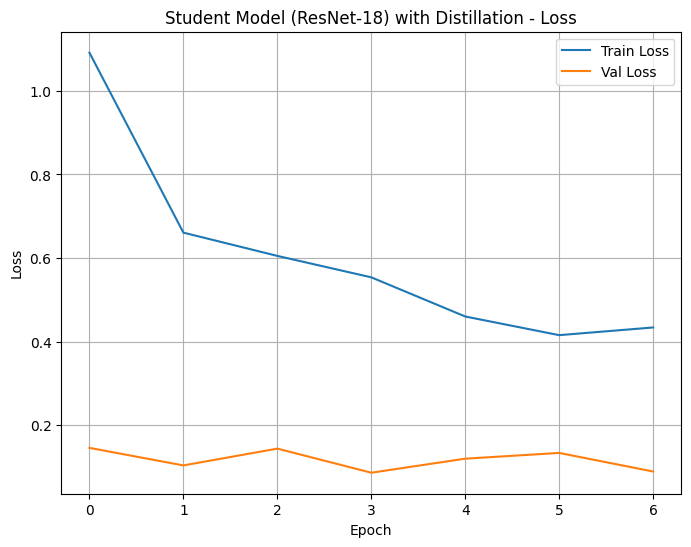

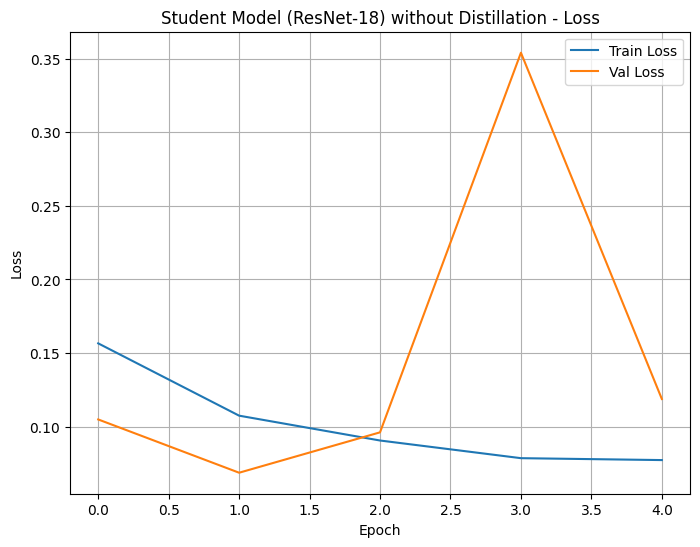


Summary Table for Student Models:
------------------------------------------------------------
| Model                     | Test Loss | Test Accuracy |
------------------------------------------------------------
| ResNet-18 (Distilled)    | 0.8205    | 82.37%       |
| ResNet-18 (No Distill)   | 0.7540    | 79.81%       |
------------------------------------------------------------

Best performing student: ResNet-18 (Distilled) with Test Accuracy: 82.37%


In [ ]:
# יצירת גרפים
def plot_loss(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history_distilled, 'Student Model (ResNet-18) with Distillation')
plot_loss(history_no_distill, 'Student Model (ResNet-18) without Distillation')

# חישוב Test Loss ו-Accuracy
distilled_test_acc, distilled_test_loss = evaluate(student_distilled, test_loader)
no_distill_test_acc, no_distill_test_loss = evaluate(student_no_distill, test_loader)

# טבלה משווה
print("\nSummary Table for Student Models:")
print("-" * 60)
print("| Model                     | Test Loss | Test Accuracy |")
print("-" * 60)
print(f"| ResNet-18 (Distilled)    | {distilled_test_loss:.4f}    | {distilled_test_acc:.2f}%       |")
print(f"| ResNet-18 (No Distill)   | {no_distill_test_loss:.4f}    | {no_distill_test_acc:.2f}%       |")
print("-" * 60)

# זיהוי התלמיד הטוב ביותר
best_student = max([
    ('ResNet-18 (Distilled)', distilled_test_acc),
    ('ResNet-18 (No Distill)', no_distill_test_acc)
], key=lambda x: x[1])
print(f"\nBest performing student: {best_student[0]} with Test Accuracy: {best_student[1]:.2f}%")

התלמיד עם דיסטילציה הראה ביצועים יותר גבוהים מסטודנט בלי דיסטילציה

חישוב לפי וקטור

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import torchvision.models as models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
temperature = 5
alpha = 0.1  # לוגיטים
beta = 0.3   # פיצ'רים


In [ ]:
teacher_base = timm.create_model('efficientnet_b3', pretrained=False, num_classes=2)
teacher_base.load_state_dict(torch.load('/content/drive/My Drive/b3.pth', map_location=device))
teacher_base.eval().to(device)


EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [ ]:
class TimmTeacherWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        feat = self.model.forward_features(x)  # [B, 1536]
        # צריך לעשות global average pooling אם הפיצ'רים הם 4D
        if len(feat.shape) == 4:  # [B, C, H, W]
            feat = F.adaptive_avg_pool2d(feat, (1, 1))
            feat = feat.view(feat.size(0), -1)  # [B, 1536]
        out = self.model.classifier(feat)  # [B, 2]
        return out, feat

teacher = TimmTeacherWrapper(teacher_base).to(device)
teacher.eval()

TimmTeacherWrapper(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_

In [ ]:
# === Student Model with Feature Alignment ===
class ResNetStudent(nn.Module):
    def __init__(self, num_classes=2, teacher_feat_dim=1536):
        super(ResNetStudent, self).__init__()
        self.model = models.resnet18(pretrained=True)
        student_feat_dim = self.model.fc.in_features  # 512 for ResNet-18

        # החלף את שכבת הסיווג
        self.model.fc = nn.Linear(student_feat_dim, num_classes)

        # הוסף שכבת יישור פיצ'רים
        self.feature_adapter = nn.Sequential(
            nn.Linear(student_feat_dim, teacher_feat_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # נעבור על השלבים עד לפני הסיווג
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        # Global Average Pooling
        features = self.model.avgpool(x)
        features = torch.flatten(features, 1)  # [B, 512]

        # סיווג
        logits = self.model.fc(features)

        # יישור פיצ'רים לגודל של המורה
        aligned_features = self.feature_adapter(features)  # [B, 1536]

        return logits, aligned_features

student = ResNetStudent(num_classes=2, teacher_feat_dim=1536).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
# === פונקציית הפסד משופרת ===
def distillation_loss(student_logits, teacher_logits, student_feat, teacher_feat, labels,
                      alpha=0.1, temperature=5.0, feature_loss_weight=0.5):
    # Cross Entropy Loss
    ce_loss = nn.CrossEntropyLoss()(student_logits, labels)

    # Knowledge Distillation Loss
    kd_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1)
    ) * (temperature ** 2)

    # Feature Matching Loss
    feat_loss = nn.MSELoss()(student_feat, teacher_feat.detach())

    total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + feature_loss_weight * feat_loss

    return total_loss, ce_loss.item(), kd_loss.item(), feat_loss.item()


In [ ]:
# === פונקציית evaluate ===
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs, _ = model(x)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [ ]:
# === אימון ===
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)

best_val_acc = 0.0
epochs_no_improve = 0
early_stop_patience = 5
epochs = 20

print("Starting Knowledge Distillation Training...")
print(f"Teacher feature dim: 1536, Student feature dim: 512 -> 1536 (aligned)")

for epoch in range(epochs):
    student.train()
    running_loss = 0.0
    running_ce_loss = 0.0
    running_kd_loss = 0.0
    running_feat_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Teacher forward pass (no gradients)
        with torch.no_grad():
            teacher_logits, teacher_feat = teacher(images)

        # Student forward pass
        student_logits, student_feat = student(images)

        # Calculate loss
        total_loss, ce_loss, kd_loss, feat_loss = distillation_loss(
            student_logits, teacher_logits, student_feat, teacher_feat, labels,
            alpha=alpha, temperature=temperature, feature_loss_weight=beta
        )

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), max_norm=1.0)
        optimizer.step()

        # Statistics
        running_loss += total_loss.item()
        running_ce_loss += ce_loss
        running_kd_loss += kd_loss
        running_feat_loss += feat_loss

    # Print epoch statistics
    avg_loss = running_loss / len(train_loader)
    avg_ce = running_ce_loss / len(train_loader)
    avg_kd = running_kd_loss / len(train_loader)
    avg_feat = running_feat_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  CE Loss: {avg_ce:.4f}, KD Loss: {avg_kd:.4f}, Feat Loss: {avg_feat:.4f}")

    # Validation
    val_acc = evaluate(student, val_loader)
    print(f"  Validation Accuracy: {val_acc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': student.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, "best_student_resnet18.pth")
        print(f"  New best model saved! Best Val Acc: {best_val_acc:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs.")
        break

    print("-" * 50)

print(f"Training completed. Best validation accuracy: {best_val_acc:.4f}")

# === Test the final model ===
print("\nLoading best model for final evaluation...")
checkpoint = torch.load("best_student_resnet18.pth")
student.load_state_dict(checkpoint['model_state_dict'])

Starting Knowledge Distillation Training...
Teacher feature dim: 1536, Student feature dim: 512 -> 1536 (aligned)
Epoch 1/20
  Total Loss: 0.3938
  CE Loss: 0.1382, KD Loss: 2.5399, Feat Loss: 0.0513
  Validation Accuracy: 0.9799
  New best model saved! Best Val Acc: 0.9799
--------------------------------------------------
Epoch 2/20
  Total Loss: 0.1525
  CE Loss: 0.0797, KD Loss: 0.7132, Feat Loss: 0.0317
  Validation Accuracy: 0.9827
  New best model saved! Best Val Acc: 0.9827
--------------------------------------------------
Epoch 3/20
  Total Loss: 0.1215
  CE Loss: 0.0602, KD Loss: 0.5787, Feat Loss: 0.0315
  Validation Accuracy: 0.9866
  New best model saved! Best Val Acc: 0.9866
--------------------------------------------------
Epoch 4/20
  Total Loss: 0.0913
  CE Loss: 0.0396, KD Loss: 0.4646, Feat Loss: 0.0308
  Validation Accuracy: 0.9866
--------------------------------------------------
Epoch 5/20
  Total Loss: 0.1052
  CE Loss: 0.0484, KD Loss: 0.5240, Feat Loss: 0.03

<All keys matched successfully>

In [ ]:
test_acc = evaluate(student, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.7692


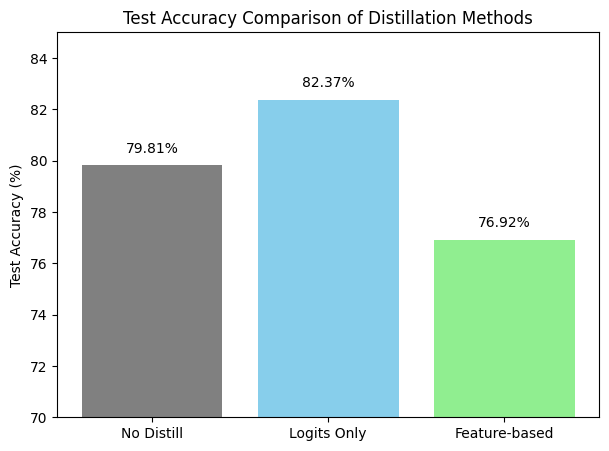

In [ ]:
import matplotlib.pyplot as plt

models = ['No Distill', 'Logits Only', 'Feature-based']
accuracy = [79.81, 82.37, 76.92]

plt.figure(figsize=(7, 5))
plt.bar(models, accuracy, color=['gray', 'skyblue', 'lightgreen'])
plt.title('Test Accuracy Comparison of Distillation Methods')
plt.ylabel('Test Accuracy (%)')
plt.ylim(70, 85)
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.5, f'{acc:.2f}%', ha='center', fontsize=10)
plt.show()


ננסה דיסטילציה משולבת של לוגיטס ופיצ'רים

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

def combined_distillation_loss(student_logits, teacher_logits,
                                student_feat, teacher_feat,
                                labels,
                                alpha=0.1,     # משקל לקידוד הרך (logits)
                                beta=0.3,      # משקל לפיצ'רים
                                temperature=5.0):


    # CrossEntropy רגילה – מטרה סטנדרטית
    ce_loss = nn.CrossEntropyLoss()(student_logits, labels)

    # KL Divergence בין הפלטים הרכים של הסטודנט והטיצ'ר
    kd_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1)
    ) * (temperature ** 2)

    # Feature Distillation – MSE בין הפיצ'רים
    feat_loss = nn.MSELoss()(student_feat, teacher_feat.detach())

    # שילוב הפסדים לפי משקלים
    total_loss = alpha * kd_loss + (1 - alpha) * ce_loss + beta * feat_loss

    return total_loss


In [ ]:
student_model = models.resnet18(pretrained=True)
student_model.fc = nn.Linear(student_model.fc.in_features, 2)
student_model = student_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
best_val_acc = 0.0
epochs_no_improve = 0
early_stop_patience = 5
epochs = 20

for epoch in range(epochs):
    student.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #מורה לא מתעדכן
        with torch.no_grad():
            teacher_logits, teacher_feat = teacher(images)

        student_logits, student_feat = student(images)

        loss = combined_distillation_loss(
            student_logits, teacher_logits,
            student_feat, teacher_feat,
            labels,
            alpha=0.7, beta=0.3, temperature=5
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # ולידציה
    val_acc = evaluate(student, val_loader)
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(student_model.state_dict(), "best_student_combined.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stop_patience:
        print("Early stopping.")
        break


Epoch 1, Loss: 0.2802
Validation Accuracy: 0.9885
Epoch 2, Loss: 0.2214
Validation Accuracy: 0.9856
Epoch 3, Loss: 0.1963
Validation Accuracy: 0.9866
Epoch 4, Loss: 0.1826
Validation Accuracy: 0.9885
Epoch 5, Loss: 0.1809
Validation Accuracy: 0.9895
Epoch 6, Loss: 0.1749
Validation Accuracy: 0.9904
Epoch 7, Loss: 0.1730
Validation Accuracy: 0.9904
Epoch 8, Loss: 0.1564
Validation Accuracy: 0.9875
Epoch 9, Loss: 0.1564
Validation Accuracy: 0.9904
Epoch 10, Loss: 0.1650
Validation Accuracy: 0.9856
Epoch 11, Loss: 0.1517
Validation Accuracy: 0.9866
Early stopping.


המודל  עם דיסטילציה מורכבת יכול להגיע לדיוק גבוה מאוד (99%)

עכשיו, ננסה את הדיסטילציה על דאטה אחר עם 4 קלאסים ולא 2

In [18]:
import zipfile
import pickle
import numpy as np
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models


In [20]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset

In [21]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import timm
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# ---- ספריות ----
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import timm
from tqdm import tqdm

In [5]:
# ---- מכשיר ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
zip_path = '/content/drive/MyDrive/cifar-10.zip'

def extract_cifar10(zip_path, extract_to='/content/cifar10_data'):
    """
    חילוץ קובץ CIFAR-10
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # אם זה tar.gz
    if zip_path.endswith('.tar.gz'):
        import tarfile
        with tarfile.open(zip_path, 'r:gz') as tar:
            tar.extractall(extract_to)
    # אם זה zip רגיל
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

    return extract_to

def load_cifar_batch(file_path):
    """
    טעינת batch בודד של CIFAR-10
    """
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')

    # המרת keys לסטרינגים
    batch = {k.decode('utf-8') if isinstance(k, bytes) else k: v for k, v in batch.items()}
    return batch

def load_and_filter_cifar10(data_dir, selected_classes=[0, 1, 2]):
    """
    טעינת CIFAR-10 וסינון לקלאסים הנבחרים
    """

    # קלאסים של CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"נבחרו הקלאסים: {[class_names[i] for i in selected_classes]}")

    # מציאת תיקיית הדאטה
    cifar_folder = None
    for root, dirs, files in os.walk(data_dir):
        if 'data_batch_1' in files:
            cifar_folder = root
            break

    if not cifar_folder:
        raise FileNotFoundError("לא נמצאה תיקיית CIFAR-10")

    # טעינת training data
    train_data = []
    train_labels = []

    for i in range(1, 6):  # data_batch_1 עד data_batch_5
        batch_path = os.path.join(cifar_folder, f'data_batch_{i}')
        batch = load_cifar_batch(batch_path)

        data = batch['data']
        labels = batch['labels']

        # סינון לקלאסים הנבחרים
        mask = np.isin(labels, selected_classes)
        filtered_data = data[mask]
        filtered_labels = np.array(labels)[mask]

        train_data.append(filtered_data)
        train_labels.extend(filtered_labels)

    # איחוד כל ה-batches
    train_data = np.vstack(train_data)
    train_labels = np.array(train_labels)

    # טעינת test data
    test_batch_path = os.path.join(cifar_folder, 'test_batch')
    test_batch = load_cifar_batch(test_batch_path)

    test_data = test_batch['data']
    test_labels = test_batch['labels']

    # סינון test data
    test_mask = np.isin(test_labels, selected_classes)
    test_data = test_data[test_mask]
    test_labels = np.array(test_labels)[test_mask]

    # מיפוי הלייבלים לטווח 0-2 (במקום 0,1,2 המקוריים)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_classes)}
    train_labels = np.array([label_mapping[label] for label in train_labels])
    test_labels = np.array([label_mapping[label] for label in test_labels])

    # עיצוב מחדש של הדאטה לתמונות 32x32x3
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # NCHW -> NHWC
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    print(f"Train data shape: {train_data.shape}")
    print(f"Train labels shape: {train_labels.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Test labels shape: {test_labels.shape}")

    print(f"התפלגות קלאסים ב-train: {np.bincount(train_labels)}")
    print(f"התפלגות קלאסים ב-test: {np.bincount(test_labels)}")

    return (train_data, train_labels), (test_data, test_labels)


In [7]:
class CIFAR3Dataset(Dataset):
    """
    Dataset מותאם ל-3 הקלאסים הראשונים של CIFAR-10
    """
    def __init__(self, original_dataset, selected_classes=[0, 1, 2]):
        self.original_dataset = original_dataset
        self.selected_classes = selected_classes

        # מצא את כל האינדקסים של הקלאסים הנבחרים
        self.indices = []
        self.new_labels = []

        # מיפוי הלייבלים הישנים לחדשים
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_classes)}

        for idx, (_, label) in enumerate(original_dataset):
            if label in selected_classes:
                self.indices.append(idx)
                self.new_labels.append(label_mapping[label])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image, _ = self.original_dataset[original_idx]
        new_label = self.new_labels[idx]
        return image, new_label

def load_cifar10_filtered(selected_classes=[0, 1, 2], data_dir='./data'):
    """
    טעינת CIFAR-10 מ-torchvision וסינון לקלאסים הנבחרים
    """

    # קלאסים של CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"מוריד CIFAR-10...")
    print(f"נבחרו הקלאסים: {[class_names[i] for i in selected_classes]}")

    # הגדרת transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # טעינת הדאטה המקורי
    original_train = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform
    )

    original_test = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=test_transform
    )

    # יצירת הדאטה המסונן
    train_dataset = CIFAR3Dataset(original_train, selected_classes)
    test_dataset = CIFAR3Dataset(original_test, selected_classes)

    print(f"Train data: {len(train_dataset)} דוגמאות")
    print(f"Test data: {len(test_dataset)} דוגמאות")

    # חישוב התפלגות הקלאסים
    train_class_counts = np.bincount([label for _, label in train_dataset])
    test_class_counts = np.bincount([label for _, label in test_dataset])

    print(f"התפלגות קלאסים ב-train: {train_class_counts}")
    print(f"התפלגות קלאסים ב-test: {test_class_counts}")

    return train_dataset, test_dataset


טוען CIFAR-10 ומסנן ל-3 קלאסים...
מוריד CIFAR-10...
נבחרו הקלאסים: ['airplane', 'automobile', 'bird']
Train data: 15000 דוגמאות
Test data: 3000 דוגמאות
התפלגות קלאסים ב-train: [5000 5000 5000]
התפלגות קלאסים ב-test: [1000 1000 1000]
מוכן לאימון! 15000 דוגמאות train, 3000 דוגמאות test
Batch shape: torch.Size([128, 3, 32, 32]), Labels: tensor([2, 0, 2, 1, 2, 0, 1, 2, 0, 0])

דוגמאות מהדאטה:


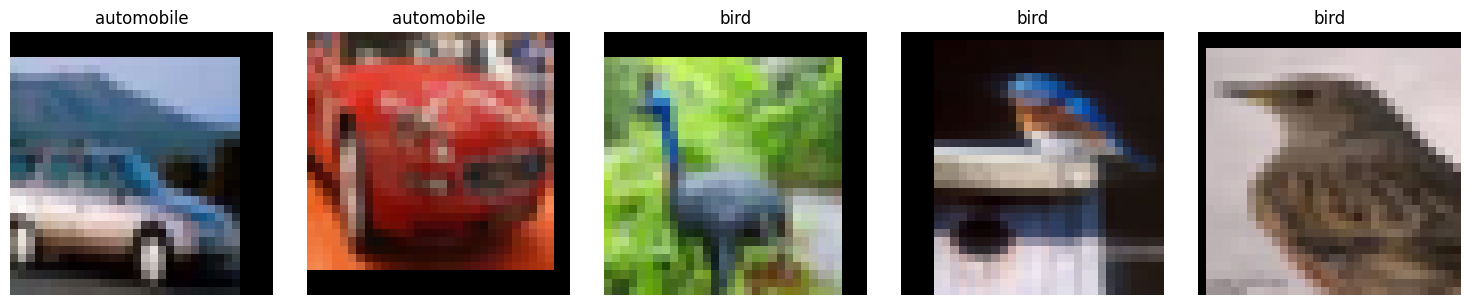

In [8]:

def load_cifar10_filtered(selected_classes=[0, 1, 2], data_dir='./data'):
    """
    טעינת CIFAR-10 מ-torchvision וסינון לקלאסים הנבחרים
    """

    # קלאסים של CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"מוריד CIFAR-10...")
    print(f"נבחרו הקלאסים: {[class_names[i] for i in selected_classes]}")

    # הגדרת transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # טעינת הדאטה המקורי
    original_train = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform
    )

    original_test = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=test_transform
    )

    # יצירת הדאטה המסונן
    train_dataset = CIFAR3Dataset(original_train, selected_classes)
    test_dataset = CIFAR3Dataset(original_test, selected_classes)

    print(f"Train data: {len(train_dataset)} דוגמאות")
    print(f"Test data: {len(test_dataset)} דוגמאות")

    # חישוב התפלגות הקלאסים
    train_class_counts = np.bincount([label for _, label in train_dataset])
    test_class_counts = np.bincount([label for _, label in test_dataset])

    print(f"התפלגות קלאסים ב-train: {train_class_counts}")
    print(f"התפלגות קלאסים ב-test: {test_class_counts}")

    return train_dataset, test_dataset

def create_dataloaders(train_dataset, test_dataset, batch_size=128, num_workers=0):
    """
    יצירת DataLoaders
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=False  # כיבוי pin_memory למניעת בעיות CUDA
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False  # כיבוי pin_memory למניעת בעיות CUDA
    )

    return train_loader, test_loader

# פונקציה להצגת דוגמאות
def show_sample_images(dataset, num_samples=5):
    """
    הצגת דוגמאות מהדאטה
    """
    import matplotlib.pyplot as plt

    class_names = ['airplane', 'automobile', 'bird']

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        image, label = dataset[i]

        # המרה חזרה לתמונה לתצוגה
        image = image.clone()
        # דנרמליזציה
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)

        # הצגה
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f'{class_names[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# שימוש בקוד:
if __name__ == "__main__":
    # טעינת הדאטה
    print("טוען CIFAR-10 ומסנן ל-3 קלאסים...")
    train_dataset, test_dataset = load_cifar10_filtered(selected_classes=[0, 1, 2])

    # יצירת data loaders
    train_loader, test_loader = create_dataloaders(train_dataset, test_dataset)

    print(f"מוכן לאימון! {len(train_dataset)} דוגמאות train, {len(test_dataset)} דוגמאות test")

    # בדיקה קצרה
    for images, labels in train_loader:
        print(f"Batch shape: {images.shape}, Labels: {labels[:10]}")
        break

    # הצגת דוגמאות (אופציונלי)
    print("\nדוגמאות מהדאטה:")
    show_sample_images(train_dataset)

In [9]:
class DistillationLoss(nn.Module):
    """
    Loss function for knowledge distillation
    """
    def __init__(self, alpha=0.5, temperature=4):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss()
        self.kl_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits, labels):
        # Standard cross-entropy loss
        hard_loss = self.ce_loss(student_logits, labels)

        # Soft targets loss
        soft_targets = torch.softmax(teacher_logits / self.temperature, dim=1)
        soft_prob = torch.log_softmax(student_logits / self.temperature, dim=1)
        soft_loss = self.kl_loss(soft_prob, soft_targets) * (self.temperature ** 2)

        # Combined loss
        total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
        return total_loss

In [10]:
def create_teacher_model(num_classes=3):
    """
    יצירת מודל המורה - EfficientNet-B3
    """
    model = models.efficientnet_b3(weights='IMAGENET1K_V1')
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.classifier[1].in_features, num_classes)
    )
    return model

In [23]:
def create_student_model(num_classes=3):
    """
    יצירת מודל התלמיד - ResNet18
    """
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [24]:
def train_teacher(model, train_loader, test_loader, epochs=10, lr=0.001, patience=3):
    """
    אימון מודל המורה עם Early Stopping
    """
    print("🎓 מאמן את המורה (EfficientNet-B3)...")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # Early stopping variables
    best_test_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Testing
        test_acc = evaluate_model(model, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

        # Early stopping check
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'✅ New best test accuracy: {best_test_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'⏳ No improvement for {patience_counter} epochs')

        if patience_counter >= patience:
            print(f'🛑 Early stopping triggered after {epoch+1} epochs')
            break

        scheduler.step()

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'🏆 Loaded best model with test accuracy: {best_test_acc:.2f}%')

    # Save model
    torch.save(model.state_dict(), 'teacher_2.pth')
    print('💾 Teacher model saved as teacher_2.pth')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'best_test_acc': best_test_acc
    }


In [30]:
def train_student_standalone(model, train_loader, test_loader, epochs=15, lr=0.001, patience=5):
    """
    אימון תלמיד רגיל (בלי דיסטילציה) עם Early Stopping
    """
    print("👨‍🎓 מאמן תלמיד רגיל (ResNet18 ללא דיסטילציה)...")

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # Early stopping variables
    best_test_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Testing
        test_acc = evaluate_model(model, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

        # Early stopping check
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'✅ New best test accuracy: {best_test_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'⏳ No improvement for {patience_counter} epochs')

        if patience_counter >= patience:
            print(f'🛑 Early stopping triggered after {epoch+1} epochs')
            break

        scheduler.step()

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'🏆 Loaded best model with test accuracy: {best_test_acc:.2f}%')

    # Save model
    torch.save(model.state_dict(), 'studentno_2.pth')
    print('💾 Student (standalone) model saved as studentno_2.pth')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'best_test_acc': best_test_acc
    }

In [44]:
def train_student_distillation(student_model, teacher_model, train_loader, test_loader,
                             epochs=15, lr=0.001, alpha=0.7, temperature=3, patience=5):
    """
    אימון תלמיד עם דיסטילציה עם Early Stopping
    """
    print("🔬 מאמן תלמיד עם דיסטילציה (ResNet18 + EfficientNet-B3)...")

    student_model = student_model.to(device)
    teacher_model = teacher_model.to(device)
    teacher_model.eval()  # המורה במצב eval

    criterion = DistillationLoss(alpha=alpha, temperature=temperature)
    optimizer = optim.Adam(student_model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # Early stopping variables
    best_test_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            # Forward pass
            student_output = student_model(data)
            with torch.no_grad():
                teacher_output = teacher_model(data)

            # Distillation loss
            loss = criterion(student_output, teacher_output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Testing
        test_acc = evaluate_model(student_model, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

        # Early stopping check
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            best_model_state = student_model.state_dict().copy()
            print(f'✅ New best test accuracy: {best_test_acc:.2f}%')
        else:
            patience_counter += 1
            print(f'⏳ No improvement for {patience_counter} epochs')

        if patience_counter >= patience:
            print(f'🛑 Early stopping triggered after {epoch+1} epochs')
            break

        scheduler.step()

    # Load best model
    if best_model_state is not None:
        student_model.load_state_dict(best_model_state)
        print(f'🏆 Loaded best model with test accuracy: {best_test_acc:.2f}%')

    # Save model
    torch.save(student_model.state_dict(), 'studentdis_2.pth')
    print('💾 Student (distilled) model saved as studentdis_2.pth')

    return student_model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'best_test_acc': best_test_acc
    }

In [45]:
def evaluate_model(model, test_loader):
    """
    הערכת מודל על דאטה test
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100. * correct / total
    return accuracy

def detailed_evaluation(model, test_loader, class_names=['airplane', 'automobile', 'bird']):
    """
    הערכה מפורטת עם confusion matrix
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # חישוב accuracy לכל קלאס
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        class_mask = np.array(y_true) == i
        if class_mask.sum() > 0:
            class_acc = (np.array(y_pred)[class_mask] == i).mean() * 100
            class_accuracies[class_name] = class_acc

    overall_accuracy = (np.array(y_pred) == np.array(y_true)).mean() * 100

    return overall_accuracy, class_accuracies

In [46]:
def plot_training_curves(teacher_history, student_history, distilled_history):
    """
    ציור גרפי האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training Loss
    axes[0,0].plot(teacher_history['train_losses'], label='Teacher (EfficientNet-B3)', marker='o')
    axes[0,0].plot(student_history['train_losses'], label='Student (standalone)', marker='s')
    axes[0,0].plot(distilled_history['train_losses'], label='Student (distilled)', marker='^')
    axes[0,0].set_title('Training Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Training Accuracy
    axes[0,1].plot(teacher_history['train_accuracies'], label='Teacher', marker='o')
    axes[0,1].plot(student_history['train_accuracies'], label='Student (standalone)', marker='s')
    axes[0,1].plot(distilled_history['train_accuracies'], label='Student (distilled)', marker='^')
    axes[0,1].set_title('Training Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy (%)')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Test Accuracy
    axes[1,0].plot(teacher_history['test_accuracies'], label='Teacher', marker='o')
    axes[1,0].plot(student_history['test_accuracies'], label='Student (standalone)', marker='s')
    axes[1,0].plot(distilled_history['test_accuracies'], label='Student (distilled)', marker='^')
    axes[1,0].set_title('Test Accuracy')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy (%)')
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Model Comparison
    final_test_accs = [
        teacher_history['test_accuracies'][-1],
        student_history['test_accuracies'][-1],
        distilled_history['test_accuracies'][-1]
    ]
    model_names = ['Teacher\n(EfficientNet-B3)', 'Student\n(standalone)', 'Student\n(distilled)']
    colors = ['blue', 'orange', 'green']

    bars = axes[1,1].bar(model_names, final_test_accs, color=colors, alpha=0.7)
    axes[1,1].set_title('Final Test Accuracy Comparison')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_ylim(0, 100)

    # הוספת ערכים על הברים
    for bar, acc in zip(bars, final_test_accs):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()


מתחיל ניסוי דיסטילציה...
🚀 מתחיל ניסוי דיסטילציה מלא!

🎓 מאמן את המורה (EfficientNet-B3)...
Epoch 1/10, Batch 0, Loss: 1.2478
Epoch 1/10, Batch 50, Loss: 0.5828
Epoch 1/10, Batch 100, Loss: 0.5787
Epoch 1/10: Train Loss: 0.6415, Train Acc: 71.84%, Test Acc: 86.20%
✅ New best test accuracy: 86.20%
Epoch 2/10, Batch 0, Loss: 0.3776
Epoch 2/10, Batch 50, Loss: 0.2881
Epoch 2/10, Batch 100, Loss: 0.4356
Epoch 2/10: Train Loss: 0.3571, Train Acc: 86.65%, Test Acc: 89.83%
✅ New best test accuracy: 89.83%
Epoch 3/10, Batch 0, Loss: 0.2915
Epoch 3/10, Batch 50, Loss: 0.3494
Epoch 3/10, Batch 100, Loss: 0.3272
Epoch 3/10: Train Loss: 0.2855, Train Acc: 89.73%, Test Acc: 92.30%
✅ New best test accuracy: 92.30%
Epoch 4/10, Batch 0, Loss: 0.1955
Epoch 4/10, Batch 50, Loss: 0.1297
Epoch 4/10, Batch 100, Loss: 0.3199
Epoch 4/10: Train Loss: 0.2357, Train Acc: 91.42%, Test Acc: 92.33%
✅ New best test accuracy: 92.33%
Epoch 5/10, Batch 0, Loss: 0.1849
Epoch 5/10, Batch 50, Loss: 0.2456
Epoch 5/10, Bat

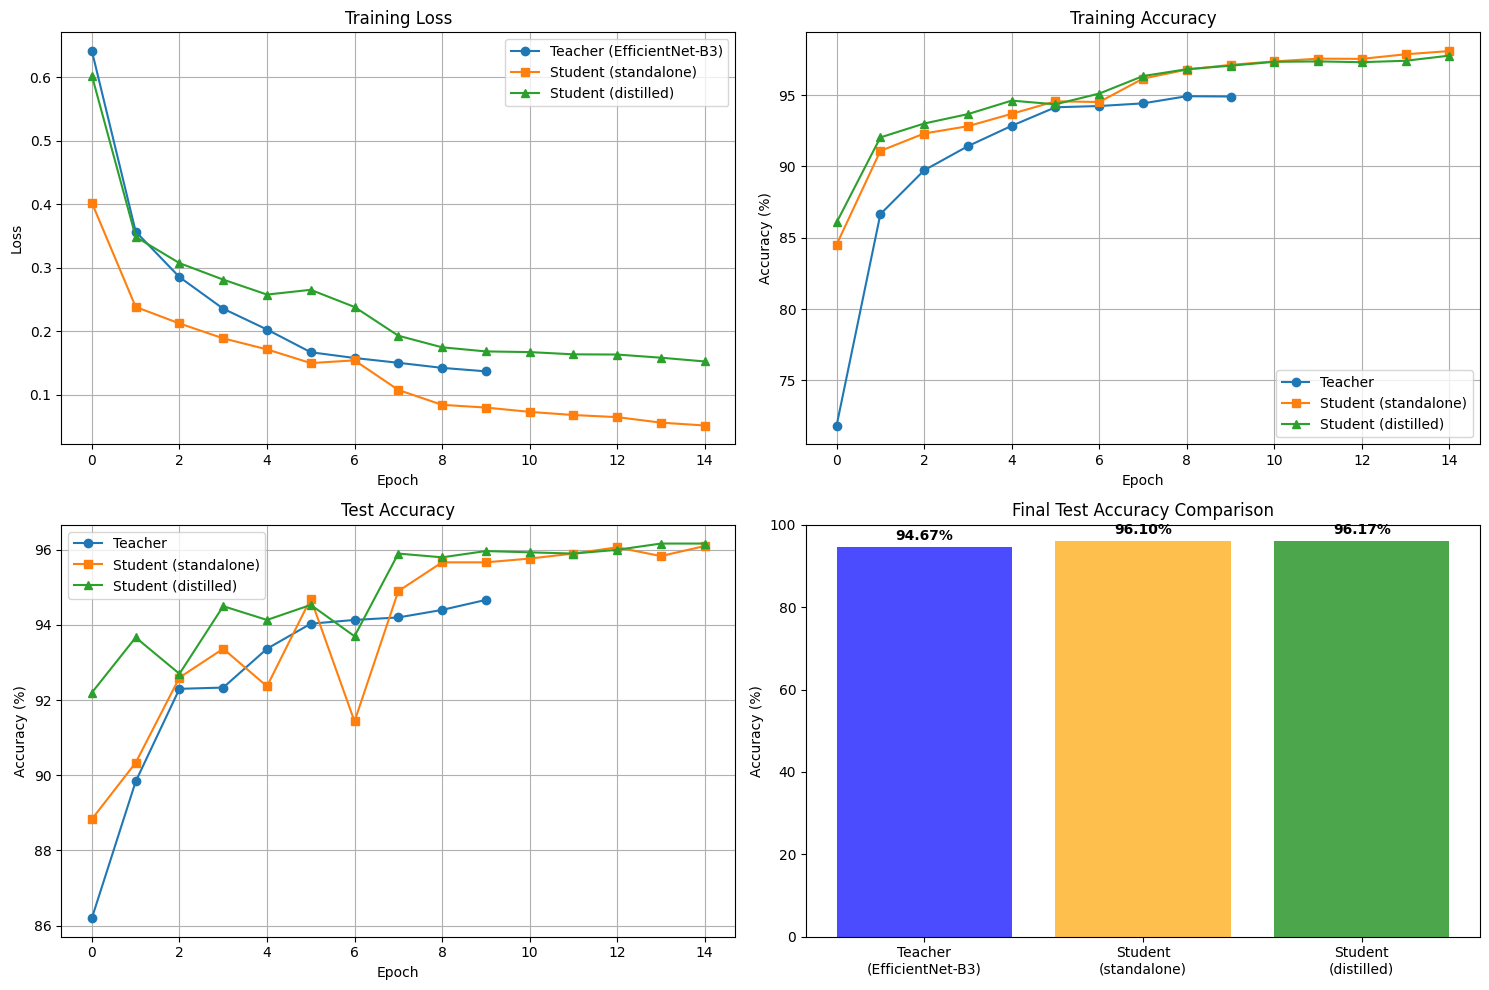

In [47]:
# הרצת הניסוי המלא
def run_full_experiment(train_loader, test_loader):
    """
    הרצת הניסוי המלא
    """
    print("🚀 מתחיל ניסוי דיסטילציה מלא!\n")

    # שלב 1: אימון המורה
    print("=" * 50)
    teacher_model = create_teacher_model()
    teacher_model, teacher_history = train_teacher(teacher_model, train_loader, test_loader, epochs=10)

    # שלב 2: אימון תלמיד רגיל
    print("\n" + "=" * 50)
    student_standalone = create_student_model()
    student_standalone, student_history = train_student_standalone(student_standalone, train_loader, test_loader, epochs=15)

    # שלב 3: אימון תלמיד עם דיסטילציה
    print("\n" + "=" * 50)
    student_distilled = create_student_model()
    student_distilled, distilled_history = train_student_distillation(
        student_distilled, teacher_model, train_loader, test_loader, epochs=15
    )

    # הערכה מפורטת
    print("\n" + "=" * 50)
    print("📊 הערכה מפורטת:")

    teacher_acc, teacher_class_acc = detailed_evaluation(teacher_model, test_loader)
    student_acc, student_class_acc = detailed_evaluation(student_standalone, test_loader)
    distilled_acc, distilled_class_acc = detailed_evaluation(student_distilled, test_loader)

    # יצירת טבלת תוצאות
    results_df = pd.DataFrame({
        'Model': ['Teacher (EfficientNet-B3)', 'Student (standalone)', 'Student (distilled)'],
        'Overall Accuracy (%)': [teacher_acc, student_acc, distilled_acc],
        'Best Test Acc (%)': [teacher_history['best_test_acc'], student_history['best_test_acc'], distilled_history['best_test_acc']],
        'Airplane Accuracy (%)': [teacher_class_acc['airplane'], student_class_acc['airplane'], distilled_class_acc['airplane']],
        'Automobile Accuracy (%)': [teacher_class_acc['automobile'], student_class_acc['automobile'], distilled_class_acc['automobile']],
        'Bird Accuracy (%)': [teacher_class_acc['bird'], student_class_acc['bird'], distilled_class_acc['bird']]
    })

    print("\n🎯 תוצאות סופיות:")
    print(results_df.to_string(index=False, float_format='%.2f'))

    # חישוב שיפור
    improvement = distilled_acc - student_acc
    print(f"\n✨ שיפור בדיסטילציה: {improvement:.2f}%")
    if improvement > 0:
        print("🎉 הדיסטילציה שיפרה את ביצועי התלמיד!")
    else:
        print("🤔 הדיסטילציה לא הביאה לשיפור משמעותי")

    print(f"\n💾 מודלים נשמרו:")
    print(f"  - teacher_2.pth (EfficientNet-B3)")
    print(f"  - studentno_2.pth (ResNet50 standalone)")
    print(f"  - studentdis_2.pth (ResNet50 distilled)")

    # ציור גרפים
    plot_training_curves(teacher_history, student_history, distilled_history)

    return {
        'teacher_model': teacher_model,
        'student_standalone': student_standalone,
        'student_distilled': student_distilled,
        'results_df': results_df,
        'histories': {
            'teacher': teacher_history,
            'student': student_history,
            'distilled': distilled_history
        }
    }

# הרצה
if __name__ == "__main__":
    # וודא שיש לך את train_loader ו-test_loader מהקוד הקודם
    print("מתחיל ניסוי דיסטילציה...")
    results = run_full_experiment(train_loader, test_loader)